In [1]:
# Conexão com o Datalake
#import datalake_serpro
#from datalake_serpro import conectando # used to conect to the datalake
#from datalake_serpro import handler_dl

# Estruturas de dados
import pandas as pd
pd.options.display.max_rows     = None
pd.options.display.max_columns  = 1000
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 1000

import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
    
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler


#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# graphic
import matplotlib.pyplot as plt

# others
import re
import itertools
import util
import math

df_di     = None
adicao_df = None


# Coleta de Dados

- Neste trabalho, serão utilizados dois datasets, sendo cada um uma tabela:
   - importacao_di: contém dados relativos às declações de importação e ao doespachoaduaneiro
   - importacao_adicao: contém dados relativos às adições das declarações de importação
   
- Data

In [2]:
# Loading data from file if the di_df is empty

try:
    di_df = pd.read_csv('di.csv', index_col=[0], low_memory=False)
except:
    di_df = None

# ajusting columns types
di_df = di_df[~di_df['ano_desembaraco'].isna()]
sorted_cols_types={
    'cd_di'                       :'string', # número da di: string
    'nr_di'                       :'int64',  # número da di: inteiro
    'qtd_adicao'                  :'int64',  
    'qtd_itens'                   :'int64',  
    'nb_canal_despacho'           :'object', 
    'nm_motivo_canal'             :'object',
    'b_cd_uan4_desp'              :'float64',
    'cd_uan4_desp'                :'string',
    'cd_respon_desemb_imp'        :'object',
    'cd_respon_regis_imp'         :'string',
    'dt_embarque'                 :'datetime64[ns]',
    'dt_chegada_veiculo'          :'datetime64[ns]',
    'dt_compl_carga_informada'    :'datetime64[ns]',
    'dt_compl_param'              :'datetime64[ns]',
    'dt_compl_recep'              :'datetime64[ns]',
    'ano_registro'                :'int64',
    'mes_registro'                :'int64',
    'dt_compl_regis'              :'datetime64[ns]',
    'ano_desembaraco'             :'int64',
    'mes_desembaraco'             :'float64',
    'dt_compl_desemb'             :'datetime64[ns]',
    'dt_compl_distr'              :'datetime64[ns]',
    'nm_loc_embq_imp'             :'object',
    'nm_modal_desp'               :'object',
    'nm_recinto_alfand'           :'object',
    'nm_sit_imp_exp'              :'object',
    'dt_dia_sit_ie'               :'datetime64[ns]',
    'nm_tipo_conhec_carga'        :'object',
    'nm_tipo_di'                  :'object',
    'nm_transpdr_imp'             :'object',
    'nr_adquir'                   :'string',
    'nr_agte_transpdr'            :'object',
    'nr_conhec_carga'             :'object',
    'nr_impdr_expdr'              :'string',
    'nr_modal_desp'               :'float64',
    'nr_recinto_alfand'           :'float64',
    'nr_rep_legal'                :'string',
    'nr_retif_imp'                :'int64',
    'nr_sit_imp_exp'              :'float64',
    'nr_tipo_conhec_carga'        :'float64',
    'nr_tipo_di'                  :'float64',
    'lista_unidade_embarque'      :'object',
    'lista_fatura_comercial'      :'object',
    'nb_pais_embq_estrg'          :'object',
    'lista_certificado_origem'    :'object',
    'lista_processo_vinculado'    :'object',
    'lista_via_transporte'        :'object',
    'lista_documentos_despacho'   :'object',
    'indicador_importacao_propria':'bool',
    'indicador_importador_mei'    :'bool',
    'indicador_adquirente_mei'    :'bool',
    'indicador_importador_simples':'bool',
    'indicador_adquirente_simples':'bool',
    'indicador_importacao_oea'    :'bool',
    'data_atualizacao'            :'datetime64[ns]',
    'vmle_dolar_imp_di'           :'float64',
    'vmle_real_imp_di'            :'float64',
    'vmcv_dolar_imp_di'           :'float64',
    'vmcv_real_imp_di'            :'float64',
    'vl_frete_dolar_imp_di'       :'float64',
    'vl_frete_real_imp_di'        :'float64',
    'vl_seguro_dolar_imp_di'      :'float64',
    'vl_seguro_real_imp_di'       :'float64',
    'vl_cif_dolar_imp_di'         :'float64',
    'vl_cif_real_imp_di'          :'float64',
    'acrescimo_real_imp_di'       :'float64',
    'deducao_real_imp_di'         :'float64',
    'peso_liq_merc_imp_di'        :'float64',
    'peso_bruto_carga_imp_di'     :'float64',
    'ii_recolher_real_imp_di'     :'float64',
    'ipi_recolher_real_imp_di'    :'float64',
    'pis_recolher_real_imp_di'    :'float64',
    'cofins_recolher_real_imp_di' :'float64',
    'nx_info_compl_imp'           :'object'
}

count = 0
# When the data are loaded from csv file, pandas assigne wrong types to the columns.
# The fallowing loop ajust the columns types
for col_name in di_df:
    #print(f'Coluna: {col_name}; tipo: {sorted_cols_types[col_name]}')
    di_df[col_name] = di_df[col_name].astype(sorted_cols_types[col_name])

# Loading the adicao_df dataframe from file
# Only two columns will be used in this project beacuse of the short time we have.
try:
    adicao_cols_types = {
        'cd_di':'object',
        'cd_subitem_ncm':'object'
        
    }
    adicao_df = pd.read_csv('di_adicao.csv', index_col=[0], dtype=adicao_cols_types, low_memory=False)
except:
    adicao_df = None

print(f"di_df.shape    : {di_df.shape}")
print(f"adicao_df.shape: {adicao_df.shape}")

di_df.shape    : (10000, 74)
adicao_df.shape: (46462, 131)


In [3]:
if di_df is None:
    # Connecting to the data lake
    connection = handler_dl(DEBUG=True, timeout= 300, shuffle= True)

    # SQL to extrac DIs retified
    sql_text = '''
    select 
        *
    from 
        coana.importacao_di 
    where
        nr_retif_imp    > 0                        and
        nm_motivo_canal = 'Fator de Aleatoriedade' and
        ano_registro in (2019,2020,2021)           and
        upper(nm_sit_imp_exp)  = upper('Desembaraçada')
    limit 5000
    union all
    -- DIs submetidas a canal e não retificadas
    select 
        *
    from 
        coana.importacao_di 
    where
        nr_retif_imp    = 0                        and
        nm_motivo_canal = 'Fator de Aleatoriedade' and
        ano_registro in (2019,2020,2021)           and
        upper(nm_sit_imp_exp)  = upper('Desembaraçada')
    limit 5000
    '''

    # Executing a query against database using pandas
    #    sqlText    -> The query text
    #    connection -> the connection returned from datalake_serpro.handler_dl
    print('Executando sql de extração das DIs')
    di_df = pd.read_sql(sql_text, connection) 
    di_df.to_csv('di.csv')

    di_list = ["'" + x + "'" for x in di_df['cd_di'].tolist()]

    print('Executando sql de extração das adições relacionadas às DIs')
    sql_text_adicao = '''
    select 
       cd_di, cd_subitem_ncm
    from 
       coana.importacao_adicao
    where
        cd_di in ({}) or 
        cd_di in ({})'''.format(",".join( di_list[:5000]), ",".join( di_list[5000:]), ",".join( di_list[5000:]) )

    adicao_df = pd.read_sql(sql_text_adicao, connection) 
    adicao_df.to_csv('di_adicao.csv')

In [4]:
# Joining the DI dataframe (di_df) and the Adicao DataFrame (adicao_df) into the di_adicao_df
di_adicao_df = di_df.merge(right=adicao_df[['cd_di','cd_subitem_ncm']], how='inner', on='cd_di')
print('DI Dataframe. Shape:{}'.format(di_df.shape))
print('Adição Dataframe. Shape:{}'.format(adicao_df.shape))
print('DI + Adição DataFrame. Shape:{}'.format(di_adicao_df.shape))

DI Dataframe. Shape:(10000, 74)
Adição Dataframe. Shape:(46462, 131)
DI + Adição DataFrame. Shape:(46462, 75)


In [5]:
# Comparing the DI count in both dataframes (di_df e adicao_df)
print('DI dataFrame. Quantidade de DIs: {}'.format(di_df['cd_di'].unique().size))
print('Adição dataFrame. Quantidade de DIs: {}'.format(adicao_df['cd_di'].unique().size))
print('Adição dataFrame. Quantidade de registros: {}'.format(adicao_df['cd_di'].count()))

DI dataFrame. Quantidade de DIs: 10000
Adição dataFrame. Quantidade de DIs: 10000
Adição dataFrame. Quantidade de registros: 46462


In [6]:
id_cols = ['cd_respon_regis_imp','nr_di', 'nr_rep_legal']
cols_to_hide = ['nr_di','ano_desembaraco','b_cd_uan4_desp','mes_desembaraco','mes_registro','nr_modal_desp','nr_recinto_alfand','nr_sit_imp_exp','nr_tipo_conhec_carga','nr_tipo_di']
di_adicao_df.describe().drop(index=['max', 'min'], columns=cols_to_hide)

,nr_retif_imp,qtd_itens,vmle_dolar_imp_di,vmle_real_imp_di,vmcv_dolar_imp_di,vmcv_real_imp_di,vl_frete_dolar_imp_di,vl_frete_real_imp_di,vl_seguro_dolar_imp_di,vl_seguro_real_imp_di,vl_cif_dolar_imp_di,vl_cif_real_imp_di,acrescimo_real_imp_di,deducao_real_imp_di,qtd_adicao,peso_liq_merc_imp_di,peso_bruto_carga_imp_di,ii_recolher_real_imp_di,ipi_recolher_real_imp_di,pis_recolher_real_imp_di,cofins_recolher_real_imp_di,ano_registro
count,"46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00","46,462.00"
mean,0.85,152.01,"413,183.39","1,870,893.87","414,188.13","1,875,442.71","4,475.40","20,423.86",67.32,298.38,"417,726.12","1,891,616.11","2,456.66",375.79,56.92,"66,021.45","918,725.15","40,895.52","16,385.59","7,518.91","35,578.30","2,019.62"
std,0.88,220.33,"20,997,079.59","91,655,974.37","20,997,171.89","91,656,352.07","20,570.82","93,582.58",461.84,"1,909.36","20,997,214.37","91,656,545.05","18,526.96","6,787.76",78.58,"1,555,212.04","4,902,005.48","87,437.90","44,406.42","24,047.35","112,705.42",0.77
25%,0.00,10.00,"16,317.27","72,343.25","16,590.58","73,135.90",584.41,"2,584.83",0.00,0.00,"18,021.35","79,259.29",0.00,0.00,4.00,232.37,"4,383.60",0.00,0.00,111.11,574.23,"2,019.00"
50%,1.00,49.00,"48,431.18","212,816.23","48,938.20","215,561.27","1,579.48","6,673.41",10.71,49.06,"50,838.85","224,587.19",436.70,0.00,20.00,"2,790.80","42,249.60","10,433.13","1,453.45","2,110.42","9,900.24","2,019.00"
75%,1.00,189.00,"125,350.70","559,015.81","127,876.21","561,054.01","3,479.74","15,824.39",56.40,243.25,"128,860.68","580,262.88","1,373.57",0.00,75.75,"12,764.75","448,490.00","45,062.15","14,373.94","7,813.56","37,495.65","2,020.00"


- Também é possível verificar que algumas colunas necessitam de normalização em razão da grande variância que apresentam.
- Este ponto será melhor analisado após a seleção de atributos (alguns serão excluídos mais à frente, como, por exemplo, o número da DI: trata-se de mero identificador que não traz grandes informações para a classificação da DI.

In [7]:
# Describing categorical data di_df
id_cols = id_cols + ['cd_di','cd_respon_desemb_imp','nr_adquir', 'nr_agte_transpdr','nr_impdr_expdr','nx_info_compl_imp']
categ = di_adicao_df.dtypes[pd.Series(list(map(lambda x: x.name,di_adicao_df.dtypes.values)), index=di_adicao_df.dtypes.index).isin(['object', 'bool', 'string'])].index
display(di_adicao_df[categ].describe().drop(columns=['cd_di','cd_respon_desemb_imp','nr_adquir', 'nr_agte_transpdr','nr_impdr_expdr','nx_info_compl_imp', 'nr_rep_legal','cd_respon_regis_imp']))

,cd_uan4_desp,nm_loc_embq_imp,nm_modal_desp,nm_recinto_alfand,nm_sit_imp_exp,nm_tipo_conhec_carga,nm_tipo_di,nm_transpdr_imp,nr_conhec_carga,nm_motivo_canal,nb_canal_despacho,lista_unidade_embarque,lista_fatura_comercial,nb_pais_embq_estrg,lista_certificado_origem,lista_processo_vinculado,lista_via_transporte,lista_documentos_despacho,indicador_importacao_propria,indicador_importador_mei,indicador_adquirente_mei,indicador_importador_simples,indicador_adquirente_simples,indicador_importacao_oea,cd_subitem_ncm
count,46462,46462,46462,46462,46462,46462,46462,46458,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462,46462
unique,81,2439,5,205,1,7,14,2768,9840,1,1,73,9805,108,1530,258,8,9979,2,2,2,2,2,2,3978
top,817800,S/Local Embarque,Normal,Aeroportos Brasil - Viracopos S/A,Desembaraçada,HBL,Consumo,S/Transportador,N/INFORMADO,Fator de Aleatoriedade,VERMELHO,0817800,VIDE INFO. COMPL.,Estados Unidos,S/CERTIFICADO ORIGEM,S/PROCESSO VINCULADO,Maritima,FATURA COMERC.VIDE INFO. COMPL.,True,False,False,False,False,False,73181500
freq,9861,2397,43619,4675,46462,25541,36220,2159,2027,46462,46462,12992,1753,10844,44525,45813,25706,1251,43982,46460,46456,46071,46027,45812,1126


# Pré-processamento

- Novas colunas
- Dados omissos
- Dados ruidosos
- outliers

### Outliers
- Nesta trabalho optou-se por se realizar um tratamento de outliers, visto que uma DI este pode ser o motivo que leva a uma retificação.


### Novas Colunas
- Algumas colunas serão criadas a partir de dados de outras colunas por se entender ser mais interessante para o projeto.
- Exemplos: 
   - A coluna nr_retif_imp, que apresenta o número de retificações de uma DI, passará a ser booleana, indicando apenas se houve ou não retificação em uma determinada DI.
   - A coluna indicativo de processo vinculado apresenta os identificadores dos processos vinculados a uma determinada DI, esta columna também passará a ser booleana indicando apenas se haverá ou não processos vinculados a uma determinada DI.

In [8]:
# Creating a target column from the 'nr_retif_imp' column
di_adicao_df['nr_retif_imp'] = di_adicao_df['nr_retif_imp'].astype('int64')
print(f"Tipos de dados na coluna retificação: {di_adicao_df['nr_retif_imp'].unique()}")

# The values of interest are: 0 - not retified; 1 - retified
di_adicao_df['retificada'] = di_adicao_df['nr_retif_imp'].apply(lambda x: 0 if x == 0 else 1)
print('Tipos de dados da nova coluna criada (retificada): {}'.format(di_adicao_df['retificada'].unique()))

# Removing the source column, so we don't have a attribute column with the same information as the target column
di_adicao_df.drop(columns='nr_retif_imp', inplace=True)
print('Coluna "nr_retif_imp" removida do dataFrame.')

Tipos de dados na coluna retificação: [ 1  2  3  5  4  6  7 10 16  0]
Tipos de dados da nova coluna criada (retificada): [1 0]
Coluna "nr_retif_imp" removida do dataFrame.


### Dados Omissos

- Para buscar os dados omissos, foi feito um filtro selecionando todas as colunas cuja contagem (quantidade de registros) fosse inferior à quantidade de linhas do dataframe principal
- Como as colunas que não estavam completas eram referentes a datas (de chegada, de carga informada etc.), optou-se, como tratamento, pela exclusão destas colunas, dado que não devem influenciar o aprendizado do modelo.

In [9]:
print(f'Quantidade de linhas di_adicao_df: {di_adicao_df.shape[0]}')
count_s = di_adicao_df.count()
print('\n\nColunas com linhas faltantes:')
cols_s = count_s[count_s < di_adicao_df.shape[0]]
cols_s

Quantidade de linhas di_adicao_df: 46462


Colunas com linhas faltantes:


dt_chegada_veiculo          43920
dt_compl_carga_informada    44197
dt_compl_distr              46148
dt_compl_param              46148
dt_compl_recep              46302
dt_embarque                 43853
nm_transpdr_imp             46458
dtype: int64

**Tratamento**:
    
- Colunas de data: optou-se pela exclusão, visto que não devem ser vinculadas a irregularidades nas DIs.
- No caso da coluna nm_transpdr_imp, considerando que ocorreu somente em uma DI, o seu valor será preenchido com o valor da moda: "HAMBURG SUDAMERIKANISCHE"

In [10]:
# Dropping date columns
date_cols = [c for c in cols_s.index if re.findall(r'dt_.*',c,flags=re.IGNORECASE)]
di_adicao_df.drop(columns=date_cols, inplace=True)

print('Agora, é possível perceber que as colunas de data já não estão mais na lista de colunas com dados faltantes.')

print(f'\nQuantidade de linhas di_adicao_df: {di_adicao_df.shape[0]}')
count_s = di_adicao_df.count()

print('\n\nColunas com linhas faltantes:')
cols_s = count_s[count_s < di_adicao_df.shape[0]]
cols_s


Agora, é possível perceber que as colunas de data já não estão mais na lista de colunas com dados faltantes.

Quantidade de linhas di_adicao_df: 46462


Colunas com linhas faltantes:


nm_transpdr_imp    46458
dtype: int64

In [11]:
# updating nm_transpdr_imp colns with the mode(most frequente value)
print('A ausência de dados para a coluna "nm_transpdr_imp" está relacionada a uma única DI:')
print(di_adicao_df[di_adicao_df['nm_transpdr_imp'].isna()]['cd_di'].unique().size)

# getting the mode value from the nm_transpdr_imp column and using it to fill the N/A Values in this same 
mode_value = di_adicao_df['nm_transpdr_imp'].mode()
print(f'\nModa para a coluna nm_transpdr_imp a ser utilizada para preencher os dados vazios: {mode_value.values[0]}')

A ausência de dados para a coluna "nm_transpdr_imp" está relacionada a uma única DI:
1

Moda para a coluna nm_transpdr_imp a ser utilizada para preencher os dados vazios: S/Transportador



 Gráfico com os valores valores mais frequentes para a coluna nm_transpdr_imp. Os nomes dos transportadores foram omitidos em razão do sigilo.


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


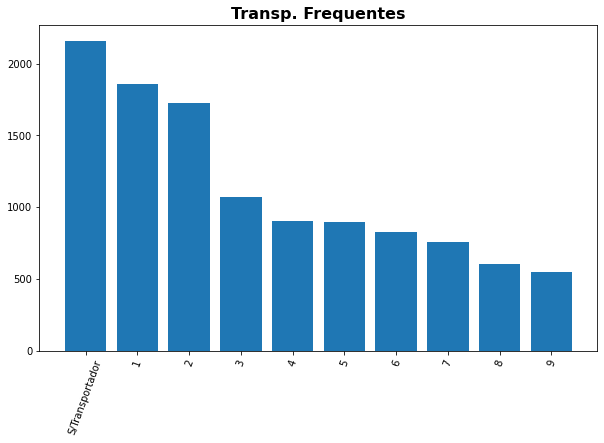

In [12]:
# Graphic display
print('\n Gráfico com os valores valores mais frequentes para a coluna nm_transpdr_imp. Os nomes dos transportadores foram omitidos em razão do sigilo.')
fig, ax = plt.subplots(figsize=(10, 6))
# getting the 10 most frequent transport companies
freq_transp = di_adicao_df['nm_transpdr_imp'].value_counts()[0:10]
# transforming labels to hide the transporter company name
labels = [(v if k==0 else k )  for k,v in enumerate(freq_transp.index.values)]

plt.title('Transp. Frequentes', fontsize = 16, fontweight = 'bold')
ax.set_xticklabels(labels=labels, rotation=70)
plt.bar(x=freq_transp.index.values, height=freq_transp.values)
plt.show()

In [13]:
# Updating the nm_transpdr_imp with the most frequent value
di_adicao_df['nm_transpdr_imp'].fillna(mode_value.values[0], inplace=True)
di_adicao_df[di_adicao_df['nm_transpdr_imp'].isna()]

,ano_desembaraco,b_cd_uan4_desp,cd_uan4_desp,cd_di,cd_respon_desemb_imp,cd_respon_regis_imp,dt_compl_desemb,dt_compl_regis,mes_desembaraco,mes_registro,nm_loc_embq_imp,nm_modal_desp,nm_recinto_alfand,nm_sit_imp_exp,dt_dia_sit_ie,nm_tipo_conhec_carga,nm_tipo_di,nm_transpdr_imp,nr_adquir,nr_agte_transpdr,nr_conhec_carga,nr_di,nr_impdr_expdr,nr_modal_desp,nr_recinto_alfand,nr_rep_legal,nr_sit_imp_exp,nr_tipo_conhec_carga,nr_tipo_di,nx_info_compl_imp,qtd_itens,nm_motivo_canal,nb_canal_despacho,lista_unidade_embarque,lista_fatura_comercial,nb_pais_embq_estrg,lista_certificado_origem,lista_processo_vinculado,lista_via_transporte,lista_documentos_despacho,indicador_importacao_propria,indicador_importador_mei,indicador_adquirente_mei,indicador_importador_simples,indicador_adquirente_simples,data_atualizacao,indicador_importacao_oea,vmle_dolar_imp_di,vmle_real_imp_di,vmcv_dolar_imp_di,vmcv_real_imp_di,vl_frete_dolar_imp_di,vl_frete_real_imp_di,vl_seguro_dolar_imp_di,vl_seguro_real_imp_di,vl_cif_dolar_imp_di,vl_cif_real_imp_di,acrescimo_real_imp_di,deducao_real_imp_di,qtd_adicao,peso_liq_merc_imp_di,peso_bruto_carga_imp_di,ii_recolher_real_imp_di,ipi_recolher_real_imp_di,pis_recolher_real_imp_di,cofins_recolher_real_imp_di,ano_registro,cd_subitem_ncm,retificada


Percebe-se que não há mais valores nulos na coluna nm_transpdr_imp, estando concluído o tratamento de dados omissos.

### Dados Ruidosos
- Abaixo, havia dados ruidosos em algumas linhas de algumas colunas
- Serão excluídas as linhas cujos importadores ou adquirentes tenham informação não numérica nas colunas nr_impr_exprd e nr_adquir


In [14]:
print("Valores númericos?")
print(di_adicao_df['nr_impdr_expdr'].astype('string').str.isnumeric().value_counts())
print(di_adicao_df['nr_adquir'].astype('string').str.isnumeric().value_counts())

Valores númericos?
True     46461
False        1
Name: nr_impdr_expdr, dtype: Int64
True     46461
False        1
Name: nr_adquir, dtype: Int64


In [15]:
# Dropping rows wich have non numeric information in the following columns: nr_impdr_expdr and nr_adquir
print("Qtde linhas df antes exclusão: {}".format(len(di_adicao_df)))
c1 = ~di_adicao_df['nr_impdr_expdr'].astype('string').str.isnumeric()
c2 = ~di_adicao_df['nr_adquir'].astype('string').str.isnumeric()
di_adicao_df.drop(index=di_adicao_df[c1 | c2].index, inplace=True)
print("Qtde linhas df antes exclusão: {}".format(len(di_adicao_df)))

Qtde linhas df antes exclusão: 46462
Qtde linhas df antes exclusão: 46461


In [16]:
print('Contagem nr_agte_transpdr não  numérico.')
c1 = ~di_adicao_df['nr_agte_transpdr'].str.isnumeric()
print(di_adicao_df[c1]['nr_agte_transpdr'].value_counts())

# Checking stringsize 
print('\nVefifica-se que todos os dados numéricos para o agente transportador possuem o tamanho de um CNPJ - 14 dígitos')
print(di_adicao_df[~c1]['nr_agte_transpdr'].apply(lambda x: len(x)).unique())

print('\nVerificando se existem os CNPJs 99999999999999 e 99999999999998')
c1 = di_adicao_df['nr_agte_transpdr'].isin(['99999999999999', '99999999999998'])
di_adicao_df[c1]['nr_agte_transpdr'].count()

print('\nAtualizando agente nr_agte_transpdr de SAgte Transpdr para 99999999999998 e de NInformado para 99999999999999')
c1 = di_adicao_df['nr_agte_transpdr'] == 'SAgte Transpdr'
di_adicao_df.loc[c1, ['nr_agte_transpdr']] = '99999999999998'
c1 = di_adicao_df['nr_agte_transpdr'] == 'NInformado'
di_adicao_df.loc[c1, ['nr_agte_transpdr']] = '99999999999999'

print('\nVerificando se ainda há algum agente transportador não numérico informado.')
c1 = ~di_adicao_df['nr_agte_transpdr'].str.isnumeric()
print(di_adicao_df[c1]['nr_agte_transpdr'].value_counts())

Contagem nr_agte_transpdr não  numérico.
SAgte Transpdr    36128
NInformado          508
Name: nr_agte_transpdr, dtype: int64

Vefifica-se que todos os dados numéricos para o agente transportador possuem o tamanho de um CNPJ - 14 dígitos
[14]

Verificando se existem os CNPJs 99999999999999 e 99999999999998

Atualizando agente nr_agte_transpdr de SAgte Transpdr para 99999999999998 e de NInformado para 99999999999999

Verificando se ainda há algum agente transportador não numérico informado.
Series([], Name: nr_agte_transpdr, dtype: int64)


### Criação de coluna com a cotação do dólar e transformação de valores em reais para dólar
- algumas informações possuem uma coluna com valor em dólar e outra com valor em real. Para uniformizar a informação, será utilizada somente a coluna em dólar, que possui menor variação ao longo do tempo.
- Outras informações, como no caso dos impostos, possuem seu valor somente em real. Assim, há a necessidade de seus valores serem transformados para dólar. Para isso, será criada uma coluna com a cotação do dólar para que as colunas em reais possam ser transformadas.

In [17]:
# Creating a column with the dolar price
di_adicao_df['vl_cotacao_dolar'] = di_adicao_df['vl_cif_real_imp_di']/di_adicao_df['vl_cif_dolar_imp_di']

# columns whose values are in dolar
real_vl_cols = ['acrescimo_real_imp_di'   ,'deducao_real_imp_di'      , 'ii_recolher_real_imp_di', 
                'ipi_recolher_real_imp_di', 'pis_recolher_real_imp_di', 'cofins_recolher_real_imp_di']

# creating a dolar column from the real column
for col in real_vl_cols:
    # The name of the new column is the name of the original column, replacing "real" for "dolar"
    # The value of the dolar column is the value of the column divided by the exchange rate calculated above
    di_adicao_df[col.replace('real','dolar')] = di_adicao_df[col]/di_adicao_df['vl_cotacao_dolar']

# Creating a list containing the old columns (with values in real) and the new columns (with value in dolar) for the dataframe display
c_list = [(x,x.replace('real','dolar')) for x in real_vl_cols]
c_list = [x for sublist in c_list for x in sublist] + ['vl_cotacao_dolar']

cond1 = di_adicao_df['acrescimo_real_imp_di']   > 0
cond2 = di_adicao_df['ii_recolher_real_imp_di'] > 0
cond3 = di_adicao_df['deducao_real_imp_di'] > 0

# the values will be grouped so we can not identify individual transactions beacuse of the data secrecy
print('Os dados foram agrupados para exibição em razão do sigilo, impedindo assim a individualiação das transações!')
di_adicao_df[ (cond1 & cond2) | cond3 ].groupby('nm_modal_desp').agg({x:'sum' for x in c_list}).head()

Os dados foram agrupados para exibição em razão do sigilo, impedindo assim a individualiação das transações!


,acrescimo_real_imp_di,acrescimo_dolar_imp_di,deducao_real_imp_di,deducao_dolar_imp_di,ii_recolher_real_imp_di,ii_recolher_dolar_imp_di,ipi_recolher_real_imp_di,ipi_recolher_dolar_imp_di,pis_recolher_real_imp_di,pis_recolher_dolar_imp_di,cofins_recolher_real_imp_di,cofins_recolher_dolar_imp_di,vl_cotacao_dolar
nm_modal_desp,,,,,,,,,,,,,
Antecipado,"1,735,290.40","448,382.25",0.00,0.00,"1,387,053.37","337,615.96","725,902.96","153,071.55","833,133.18","206,411.32","3,828,445.99","948,509.30",87.55
Entrega Fracionada,0.00,0.00,"13,991,587.42","2,804,380.20",0.00,0.00,0.00,0.00,"508,975.96","95,840.57","2,338,866.01","440,410.27",677.51
Normal,"61,152,765.99","13,535,269.62","3,468,255.91","711,520.80","1,293,478,347.51","289,095,361.14","425,301,413.62","97,364,950.99","193,740,671.58","43,428,428.89","912,113,462.11","204,758,281.78","75,918.55"
S/Modal Desp,"6,651,357.53","1,618,255.75",0.00,0.00,"146,514,837.41","35,943,442.48","50,592,078.88","12,706,383.90","45,186,797.76","11,095,652.16","221,545,800.82","54,421,054.54","8,804.98"


### Criação da coluna PROC_VINCULADO_BOOL e CERTF_ORIG_BOOL
- A coluna indica se há algum processo vinculado à DI ou não.
- A coluna é criada a partir da coluna lista_processo_vinculado
- Endente-se que o número do processo pode não ser tão relevante para a retificação de uma DI, mas a existência ou não de processo vinculado pode ser, por isso foi criada nova coluna booleana indicando a existência ou não de processo vinculado.

- A mesma ideia foi aplicada à coluna lista_certificado_origem, o que resultou na nova coluna certf_orig_bool

In [18]:
di_adicao_df['proc_vinculado_bool'] = ~(di_adicao_df['lista_processo_vinculado'] == 'S/PROCESSO VINCULADO')
print('Processo vinculado: ')
print(di_adicao_df['proc_vinculado_bool'].value_counts())

di_adicao_df['certf_orig_bool'] = ~(di_adicao_df['lista_certificado_origem'] == 'S/CERTIFICADO ORIGEM')
print('\n\n Certificado de origem:')
print(di_adicao_df['certf_orig_bool'].value_counts())


Processo vinculado: 
False    45812
True       649
Name: proc_vinculado_bool, dtype: int64


 Certificado de origem:
False    44524
True      1937
Name: certf_orig_bool, dtype: int64


**Tratamento da coluna: lista_fatura_comercial e nr_conhec_carga**

A quantidade de valores únicos é muito próxima da quantidade total de DIs, o que pode haver valores repetidos em DIs, o que provavelmente indica alguma informação pelo sistema de ausência de fatura.

Neste caso, será criada uma coluna booleana indicando a existência ou não de fatura.


In [19]:
print(f"Quantidade de valores únicos: {di_adicao_df['lista_fatura_comercial'].unique().size}")
print(f"Quantidade de registros com 'S/N' - sem número - informado: {di_adicao_df[di_adicao_df['lista_fatura_comercial']=='S/N']['cd_di'].unique().size}")    

# creating the column fatura_comercial_bool from the column lista_fatura_comercial
di_adicao_df['fatura_comercial_bool'] = di_adicao_df['lista_fatura_comercial'].apply(lambda x: 0 if x.upper() == 'S/N' else 1)
print(f"\nColuna fatura_comercial_bool, valores: \n{di_adicao_df['fatura_comercial_bool'].value_counts()}")
      
# Creating conhec_carga_bool column from nr_conhec_carga
di_adicao_df['conhec_carga_bool'] = di_adicao_df['nr_conhec_carga'].apply(lambda x: 0 if x == 'N/INFORMADO' else 1)
print(f"\nColuna conhec_carga_bool, valores:\n{di_adicao_df['conhec_carga_bool'].value_counts()}")


Quantidade de valores únicos: 9805
Quantidade de registros com 'S/N' - sem número - informado: 27

Coluna fatura_comercial_bool, valores: 
1    46338
0      123
Name: fatura_comercial_bool, dtype: int64

Coluna conhec_carga_bool, valores:
1    44434
0     2027
Name: conhec_carga_bool, dtype: int64


### Feature selection
- Inicialmente, visto que pode ocorrer erro no treinamento dos modelos (especialmente na regressão logística), os campos do tipo datetime foram removidos, inclusive pela falta de interesse em se classificar uma DI com base nas datas.

In [20]:
removed_cols = [
    # Removed columns
    'ano_desembaraco', # o ano de ve ser irrelevante para a identificação de irregularidades
    'cd_di', # mero identificador,
    'nr_di', # identificador
    'mes_desembaraco',# coluna de desembaraço já é posterior à retificação
    'ano_registro', # o ano deve ser irrelevante para a classificação
    'nr_sit_imp_exp', # todas as dis estão desembaraçadas
    'b_cd_uan4_desp', # formato numérico da unidade de despacho (há outro campo com essa informação em string)
    'nm_sit_imp_exp', # foram selecionadas apaenas DIs desembaraçadas
    'nr_modal_desp', # mesmo significado da coluna nm_modal_desp
    'nr_tipo_conhec_carga', # mesmo significado da coluna nm_tipo_conhec_carga
    'nr_tipo_di', # mesmo significado da colluna nm_tipo_di
    'nm_motivo_canal', # fator de aleatoriedade para todas as DIs
    'vmle_real_imp_di', #possui uma coluna equivalente em dólar ao longo do tempo
    'vmcv_real_imp_di', #possui uma coluna equivalente em dólar ao longo do tempo
    'vl_frete_real_imp_di', #possui uma coluna equivalente em dólar ao longo do tempo
    'vl_seguro_real_imp_di', #possui uma coluna equivalente em dólar ao longo do tempo
    'vl_cif_real_imp_di',    #possui uma coluna equivalente em dólar ao longo do tempo
    'vl_cotacao_dolar', # created only to make possible to chage the value of some columns to dolar
    'acrescimo_real_imp_di', # it was created an equivalent column with value in dolar
    'deducao_real_imp_di',   # it was created an equivalent column with value in dolar
    'ii_recolher_real_imp_di', # it was created an equivalente column with the value in dolar
    'ipi_recolher_real_imp_di', # it was created an equivalente column with the value in dolar
    'pis_recolher_real_imp_di',  # it was created an equivalent colunm with the value in dolar
    'cofins_recolher_real_imp_di', # it was created an equivalent column with the value in dolar
    'lista_documentos_despacho', # this column has only document numbers and no information at all 
    'lista_processo_vinculado', # this column was replaced by lista_processo_vinculado_bool, wich indicates whether a DI has or hasn't a attached proccess
    'lista_certificado_origem', # this column was replaced by the certf_orig_bool created column
    'nb_canal_despacho', # removed beacuse the goal is to identify the potentialy irregular DI, regardless the channel the DI was selected to
    'nx_info_compl_imp', # desciption column - removed from the first model
    'lista_fatura_comercial', # this column was replace by lista_fatura_bool
    'mes_registro', # pode ter uma relevância pela sasonalidade (o registro de alguns produtos podem gerar mais erros do que outros)
    'lista_unidade_embarque', # column not found 
    'nr_conhec_carga', # replaced by conhec_carga_bool
    'nr_recinto_alfand', #redundant with nm_recinto_alfand
    'nb_pais_embq_estrg', # redundant with nm_loc_embq_imp
]

# remained columns
cols_list_df = {
    'col_name':[
        'cd_di',
        'cd_uan4_desp' ,# inicialmente permanecerá, visto que algumas unidades podem ter análises mais criterioósas que outras
        'nm_recinto_alfand',
        'nm_loc_embq_imp', # As mercadorias procedentes de algumas localidades podem estar mais sujeitas a erros do que outras
        'nm_modal_desp', #['Normal', 'S/Modal Desp', 'Antecipado', 'Entrega Fracionada','Sobre Águas OEA']
        'nm_tipo_conhec_carga', #['HBL', 'HAWB', 'S/Con Carga', 'AWB', 'CRT', 'DSIC', 'CP2']
        'nm_tipo_di', #[Admissao Na Zfm - Zona Franca De Manaus, Consumo, Admissao Em De/Daf, Nacionalizacao De Entreposto Aduaneiro, Admissao Em Entreposto Aduaneiro, Consumo E Admissao Temporaria, Admissao Temporaria, Admissao Em Entreposto Industrial, Admissao Em Eizof - Entreposto Internacional Da Zfm, Saida De Eizof - Entreposto Internacional Da Zfm, Saida De Entreposto Industrial, Admissao Em Loja Franca, Nacionalizacao De Admissao Temporaria, Nacionalizacao De Dea - Deposito Especial Alfandegado]
        'nm_transpdr_imp',
        'cd_respon_desemb_imp', # inicialmente, permanecerá, visto que algum auditor pode ter análises mais criteriosas que outras 
        'cd_respon_regis_imp', # a ideia é impessoalizar a análise, entretanto, o responsábel pelo registro da DI é relevante, dada a grande diferença de capacidade técnica entre os que procedem ao registro
        'nr_adquir',
        'nr_agte_transpdr',
        'nr_impdr_expdr',
        'nr_rep_legal',
        'qtd_itens',
        'indicador_importacao_propria',
        'indicador_importador_mei',
        'indicador_adquirente_mei',
        'indicador_importador_simples',
        'indicador_adquirente_simples',
        'indicador_importacao_oea',
        'qtd_adicao',
        'vmle_dolar_imp_di',
        'vmcv_dolar_imp_di',
        'vl_frete_dolar_imp_di',
        'vl_seguro_dolar_imp_di',
        'vl_cif_dolar_imp_di',
        'peso_liq_merc_imp_di',
        'peso_bruto_carga_imp_di',
        'acrescimo_dolar_imp_di',
        'deducao_dolar_imp_di',
        'ii_recolher_dolar_imp_di',
        'ipi_recolher_dolar_imp_di',
        'pis_recolher_dolar_imp_di',
        'cofins_recolher_dolar_imp_di',
        'lista_via_transporte', # ['Maritima', 'Aerea', 'Maritima, Aerea' 'Rodoviaria', 'Aerea, Maritima', 'Entrada/Saida Ficta', 'Conduto / Rede Transmissão', 'Postal']
        'proc_vinculado_bool', # this column was created from the lista_processo_vinculado indicating whether the DI has or hasn't a linked proccess
        'certf_orig_bool', # This column was created from the lista_certificado_origem column, indicating wheter the DI has or hasn't origim certificate
        'fatura_comercial_bool', # this column was created from lista_fatura_comercial and incidates whether the DI has orr has not commercial invoice informed
        'cd_subitem_ncm',
        'conhec_carga_bool',
        'retificada'
    ],
    'encoded':[ 
        'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none',
        'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none',
        'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none',
        'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none',  'none' 
    ],
}

cols_list_df = pd.DataFrame(cols_list_df)

train_df = di_adicao_df[cols_list_df['col_name']].copy()
print('A saída exemplificativa dos dados foi agregada para impedir a individualização das transações.')
display(train_df.groupby(['nm_modal_desp']).agg({'vmle_dolar_imp_di': 'sum', 'vmcv_dolar_imp_di': 'sum', 'vl_frete_dolar_imp_di': 'sum', 'vl_seguro_dolar_imp_di': 'sum', 'vl_cif_dolar_imp_di': 'sum', 'peso_liq_merc_imp_di': 'sum', 'peso_bruto_carga_imp_di': 'sum', 'acrescimo_dolar_imp_di': 'sum', 'deducao_dolar_imp_di': 'sum', 'ii_recolher_dolar_imp_di': 'sum', 'ipi_recolher_dolar_imp_di': 'sum', 'pis_recolher_dolar_imp_di': 'sum', 'cofins_recolher_dolar_imp_di': 'sum'}).head())

print(train_df.columns)

A saída exemplificativa dos dados foi agregada para impedir a individualização das transações.


,vmle_dolar_imp_di,vmcv_dolar_imp_di,vl_frete_dolar_imp_di,vl_seguro_dolar_imp_di,vl_cif_dolar_imp_di,peso_liq_merc_imp_di,peso_bruto_carga_imp_di,acrescimo_dolar_imp_di,deducao_dolar_imp_di,ii_recolher_dolar_imp_di,ipi_recolher_dolar_imp_di,pis_recolher_dolar_imp_di,cofins_recolher_dolar_imp_di
nm_modal_desp,,,,,,,,,,,,,
Antecipado,"298,291,569.89","316,169,071.39","26,625,135.23","113,988.29","325,030,693.41","1,228,683,886.63","1,402,546,539.38","5,576,656.15",0.00,"435,637.58","311,631.96","3,088,459.01","14,222,852.20"
Entrega Fracionada,"42,004,208.22","46,366,870.77","1,754,075.06","19,443.68","43,777,726.96","162,730,970.00","165,033,652.54",0.00,"2,804,380.20",0.00,0.00,"119,998.51","551,421.86"
Normal,"18,324,572,184.00","18,344,488,409.04","164,055,281.36","2,899,217.22","18,491,526,682.58","1,615,773,958.26","30,337,738,360.71","18,200,086.47","711,520.80","387,578,945.17","158,416,524.28","63,859,219.08","301,281,988.21"
S/Modal Desp,"528,235,969.17","532,756,220.56","15,465,845.94","95,031.77","543,796,846.88","60,122,755.49","10,773,995,217.51","1,726,687.43",0.00,"36,429,097.59","13,003,591.90","11,382,233.54","55,763,768.25"
Sobre Águas OEA,"4,147,590.08","4,153,448.39","33,105.63",369.10,"4,181,064.81","173,639.56","6,490,998.90","2,444.57",0.00,"1,277.54",0.00,"1,341.42","6,164.16"


Index(['cd_di', 'cd_uan4_desp', 'nm_recinto_alfand', 'nm_loc_embq_imp',
       'nm_modal_desp', 'nm_tipo_conhec_carga', 'nm_tipo_di',
       'nm_transpdr_imp', 'cd_respon_desemb_imp', 'cd_respon_regis_imp',
       'nr_adquir', 'nr_agte_transpdr', 'nr_impdr_expdr', 'nr_rep_legal',
       'qtd_itens', 'indicador_importacao_propria', 'indicador_importador_mei',
       'indicador_adquirente_mei', 'indicador_importador_simples',
       'indicador_adquirente_simples', 'indicador_importacao_oea',
       'qtd_adicao', 'vmle_dolar_imp_di', 'vmcv_dolar_imp_di',
       'vl_frete_dolar_imp_di', 'vl_seguro_dolar_imp_di',
       'vl_cif_dolar_imp_di', 'peso_liq_merc_imp_di',
       'peso_bruto_carga_imp_di', 'acrescimo_dolar_imp_di',
       'deducao_dolar_imp_di', 'ii_recolher_dolar_imp_di',
       'ipi_recolher_dolar_imp_di', 'pis_recolher_dolar_imp_di',
       'cofins_recolher_dolar_imp_di', 'lista_via_transporte',
       'proc_vinculado_bool', 'certf_orig_bool', 'fatura_comercial_bool',
       'c

### Registros Duplicados

In [21]:
# Finding and dropping duplicated records

# Getting the quantity of duplicated records
qtty = len(train_df[train_df.duplicated(keep='first')])
print(f'Quantidade de registros duplicados: {qtty}')

# Dropping duplicated records
train_df.drop_duplicates(keep='first',inplace=True)
print(f"Quantidade de registros restantes no dataFrame: {len(train_df)}")

Quantidade de registros duplicados: 15496
Quantidade de registros restantes no dataFrame: 30965


### Encoding columns

- As colunas precisam ser convertidas para números antes da indução de alguns modelos. Para algumas colunas numéricas, foi atribuído o tipo de dado 'string'. Elas serão simplesmente convertidas para números.

- Além disso, serão utilizados dois tipos de codificação de colunas categóricas:
    - Label enconder: será aplicados às colunas de identificação dos intervenientes
    - one-hot-encoder: variáveis não ordinais (será executado após a análise exploratória)

In [22]:
# creating a list of columns that are going to be ecoded (non-numerical)
dummy_encode_cols = [
    'nm_recinto_alfand', 'nm_loc_embq_imp', 'nm_modal_desp'       , 'nm_tipo_conhec_carga',
    'nm_tipo_di'       , 'nm_transpdr_imp', 'lista_via_transporte'
]

# is was necessary to convert the columns to number before training the models
# Gettinga all string columns
cols_to_convert = train_df.dtypes[train_df.dtypes.apply(lambda x: x.name in ({'object', 'string'}))].index.values.tolist()
# Excluding the columns that will be encoded with One-hot Encoder
cols_to_convert = [x for x in cols_to_convert if x not in dummy_encode_cols]

# Converting each column to int64
for col in cols_to_convert:
    print(f'Convertendo coluna "{col}" para número!')
    train_df[col] = train_df[col].astype('int64')
train_df[cols_to_convert].dtypes

Convertendo coluna "cd_di" para número!
Convertendo coluna "cd_uan4_desp" para número!
Convertendo coluna "cd_respon_desemb_imp" para número!
Convertendo coluna "cd_respon_regis_imp" para número!
Convertendo coluna "nr_adquir" para número!
Convertendo coluna "nr_agte_transpdr" para número!
Convertendo coluna "nr_impdr_expdr" para número!
Convertendo coluna "nr_rep_legal" para número!
Convertendo coluna "cd_subitem_ncm" para número!


cd_di                   int64
cd_uan4_desp            int64
cd_respon_desemb_imp    int64
cd_respon_regis_imp     int64
nr_adquir               int64
nr_agte_transpdr        int64
nr_impdr_expdr          int64
nr_rep_legal            int64
cd_subitem_ncm          int64
dtype: object

In [23]:
# LabelEncoder
# The original column will be replaced by the encoded column

# Columns to b e encoded
id_columns = ['nr_adquir', 'nr_agte_transpdr','nr_impdr_expdr','cd_respon_regis_imp', 'nr_rep_legal', 'cd_respon_desemb_imp']

# Creating a dict to store the ecoder for each column in case it is need to inverse encode the data
le_ident_dct = {}

for col in id_columns:
    le_ident_dct[col] = LabelEncoder()
    
    # Encoding and replacing the original column
    train_df[col] = le_ident_dct[col].fit_transform(train_df[col])
    
#train_df[id_columns].sample(frac=1).head()


In [24]:
##########################
#       One-Hot Encoder
##########################
# updating the cols_list_df to indicated the columns that are being submitted to encoding
cols_list_df.loc[cols_list_df['col_name'].isin(dummy_encode_cols), 'encoded'] = True
cols_list_df

# define one hot encoding
encoder = OneHotEncoder(sparse=True)
# transform data
enconde_data = encoder.fit_transform(train_df[dummy_encode_cols])
# generating a name for each column created by One-HotEncoder, composed by col_name_col_value
features_names = encoder.get_feature_names(train_df[dummy_encode_cols].columns.values)
# Creating a dataframe from the enncoded data
encoded_df = pd.DataFrame(enconde_data.toarray(),columns=features_names, index=train_df.index)

print("A título de exemplo, segue a codificação da coluna ['lista_via_transporte'].")

cols_to_show = [x for x in encoded_df.columns.values if x.startswith('lista_via_transporte')]

encoded_df[encoded_df[cols_to_show[0] ]== 1][cols_to_show].head()

A título de exemplo, segue a codificação da coluna ['lista_via_transporte'].


,lista_via_transporte_Aerea,"lista_via_transporte_Aerea, Maritima",lista_via_transporte_Conduto / Rede Transmissão,lista_via_transporte_Entrada/Saida Ficta,lista_via_transporte_Maritima,"lista_via_transporte_Maritima, Aerea",lista_via_transporte_Postal,lista_via_transporte_Rodoviaria
7,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
17,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
19,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
########################################################################
#  Join the train_df with encoded columns DF
########################################################################
# Dropping the categorical transformed variables from datafram train_df and joinning the remaining columns with encoded dataframe
print(f"Quantidade de colunas antes do join: {train_df.columns.values.size}")
train_encoded_df = train_df.drop(columns=dummy_encode_cols).join(encoded_df) 
print(f"Quantidade de colunas após o join: {train_encoded_df.columns.values.size}")
#train_encoded_df.head(10)

Quantidade de colunas antes do join: 42
Quantidade de colunas após o join: 5481


# Análise exploratória

### Oversampling and undersampling

- A extração dos dados das DIs foi realizada buscando um balanceamento de carga (5000 registras para DIs retificadas e 5000 para DIs não retificadas)
- Após o join com os dados das adições, houve o desbalanceamento das classes (38% para DIs não retificadas), visto que a quantidade de adições é variável em cada DI.
- Em um primeiro momento, optou-se por treinar o modelo sem trabalhar o balancemaneto. Adiante, avaliar-se-á o rebalanceamento para evitar o undersampling de uma das classes, que, inicialmente, entende-se não haver.

In [26]:
print('Quantidade de registros por classe (0-não retificada; 1 - retificada)')
print('Nível da DI:')
df_aux = train_encoded_df.groupby(['cd_di','retificada'], as_index=False).agg({'cd_di':'count'}).groupby('retificada').agg({'cd_di':'count'}).rename(columns={'cd_di':'nível_di'})
df_aux['nível_di_%'] = df_aux['nível_di'].apply(lambda x: (x/df_aux['nível_di'].sum()*100))
print('Nível da adição:')
df_aux = df_aux.merge(train_encoded_df.groupby('retificada').agg({'cd_subitem_ncm':'count'}), left_index=True, right_index=True).rename(columns={'cd_subitem_ncm':'nível_subitem'})
df_aux['nível_subitem_%'] = df_aux['nível_subitem'].apply(lambda x: (x/ df_aux['nível_subitem'].sum())*100)
df_aux

Quantidade de registros por classe (0-não retificada; 1 - retificada)
Nível da DI:
Nível da adição:


,nível_di,nível_di_%,nível_subitem,nível_subitem_%
retificada,,,,
0,4999,49.99,11851,38.27
1,5000,50.01,19114,61.73


- O dataset das DIs está balanceado, havendo 5000 registros para cada uma das classes alvo (0 - DI não retificada; 1 - DI retificada)
- Quando se consideram as NCMs (detalhe das DIs - cada DI pode ter uma ou mais NCMs), percebe-se que ocorre o desbalanceamento das classes.

- Na célula acima fica claro um desbalanceamento ocasionado pelo join entre os DIs e as respectivas adições
- À frente, os modelos serão treinados
   - com a base desbalanceada
   - com a base balanceada excluindo-se os DIs retificadas para aproximar as DIs retificadas e as não retificadas
   - com um dataset tratado para deixar uma linha por DI, transformando-se as ncms em colunas
   
- É possível perceber que DIs retificadas tentem a ter mais adições

### Correlção

- Abaixo, segue a correlação entre a coluna "retificada" e os demais atributos.
- É possível perceber que a coluna qtde_adição é a que apresenta a maior correlação
- Entretanto, nenhuma correlação pode ser considerada relevante.

In [27]:
line = ''
count_cols = 0
just_size1 = 30
just_size2 = 8
title_dash_size = 38
print('-'*title_dash_size + ' Correlação retificada x demais atributos ' + '-'*title_dash_size )
print('')
print('Coluna'.ljust(just_size1),'Corr.'.ljust(just_size2),'Coluna'.ljust(just_size1),'Corr.'.ljust(just_size2),'Coluna'.ljust(just_size1),'Corr.'.ljust(just_size2))
aux_df = pd.DataFrame(train_df.drop(columns=['cd_di']).corr()['retificada']).sort_values(by='retificada', ascending=False)
for k,v in aux_df.iterrows():
    count_cols += 1
    
    line += f"{k.ljust(29)}:{str(round(v['retificada'],4)).ljust(6,'0').rjust(7, ' ') if v['retificada'] > 0 else str(round(v['retificada'],4)).ljust(7,'0')}".ljust(38) + "| " 
    
    if (count_cols % 3 == 0) | (count_cols == aux_df.size):
        print(line)
        line = ''

-------------------------------------- Correlação retificada x demais atributos --------------------------------------

Coluna                         Corr.    Coluna                         Corr.    Coluna                         Corr.   
retificada                   : 1.0000 | qtd_adicao                   : 0.1458 | qtd_itens                    : 0.1354 | 
cd_subitem_ncm               : 0.1316 | conhec_carga_bool            : 0.1181 | peso_bruto_carga_imp_di      : 0.0502 | 
acrescimo_dolar_imp_di       : 0.0461 | vl_frete_dolar_imp_di        : 0.0418 | ii_recolher_dolar_imp_di     : 0.0386 | 
pis_recolher_dolar_imp_di    : 0.0266 | cofins_recolher_dolar_imp_di : 0.0265 | peso_liq_merc_imp_di         : 0.0230 | 
vl_seguro_dolar_imp_di       : 0.0171 | indicador_adquirente_simples : 0.0137 | indicador_adquirente_mei     : 0.0110 | 
ipi_recolher_dolar_imp_di    : 0.0089 | indicador_importador_mei     : 0.0063 | indicador_importador_simples : 0.0063 | 
vl_cif_dolar_imp_di          : 0.0

### Coluna: qtd_adicao

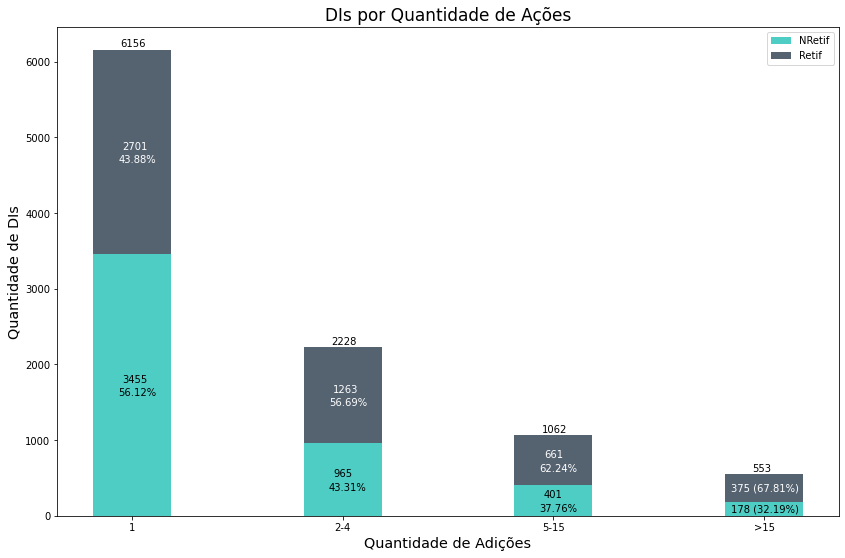

In [28]:
def get_class(x):
    if x == 1:
        return '1'
    elif (x > 1) & (x<=4):
        return '2-4'
    elif (x > 4) & (x<=15):
        return '5-15'
    else:
        return '>15'


cols = train_df.drop(columns=['cd_subitem_ncm']).columns.tolist()
cols.remove('retificada')
aux_df = train_df.groupby(cols, as_index=False).mean()[['qtd_adicao', 'retificada']]
aux_df['qtd_di'] = 1

aux_df['class_adicao']=aux_df['qtd_adicao'].apply(get_class)
aux_df = aux_df.groupby(['class_adicao', 'retificada'], as_index=False).count()
aux_df = aux_df.sort_values(by='class_adicao', key=lambda col: col.apply(lambda x: int(x.split('-')[0]) if '-' in x else int(x.replace('>','')) ))

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(14,9))
#fig.suptitle('DIs por Quantidade de Ações', fontsize=20)

N = aux_df['class_adicao'].unique().size
n_ret_data = aux_df[aux_df['retificada']==0]['qtd_di']
ret_data   = aux_df[aux_df['retificada']==1]['qtd_di']
ind = np.arange(N)    # the x locations for the groups
width = 0.37       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, n_ret_data, width, label='NRetif', color='#4ECDC4')
p2 = ax.bar(ind, ret_data, width,
            bottom=n_ret_data, label='Retif', color='#556270')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Quantidade de DIs', fontsize='x-large')
ax.set_xlabel('Quantidade de Adições', fontsize='x-large')
ax.set_title('DIs por Quantidade de Ações', fontsize=17)
ax.set_xticks(ind)
ax.set_xticklabels(labels=aux_df['class_adicao'].unique())
ax.legend()

label_values_total = aux_df.groupby('class_adicao', as_index=False)['qtd_di'].sum()['qtd_di'].values.tolist()
for k,b in enumerate(p1.patches):
    # Getting the controller for the bar wich represents the rectified DIs
    b2 = p2.patches[k]
    
    # Considering the column is to low, we have to put the percentage in the same linea as the abs value
    if label_values_total[k] < 600:
        # Not Rectified DIs
        ax.text(b.xy[0]+0.03,b.get_height()/2-40, str(b.get_height()) + f" ({str(round(b.get_height()/label_values_total[k]*100,2))}%)",c='black')
        
        # rectified DIs
        ax.text(b2.xy[0]+0.03,b2.xy[1]+b2.get_height()/2-40, str(b2.get_height()) + f" ({str(round(b2.get_height()/label_values_total[k]*100,2))}%)",c='white')
    
    # In this case, the parcentage value will be displayed under the  absolute values
    else:
        # Not retified
        ax.text(b.xy[0]+0.14,b.get_height()/2+40, str(b.get_height()),c='black')
        ax.text(b.xy[0]+0.12,b.get_height()/2-140, str(round(b.get_height()/label_values_total[k]*100,2))+'%',c='black')
        
        # Retified
        ax.text(b2.xy[0]+0.14,(b2.xy[1]+b2.get_height()/2+40), b2.get_height(), c='white') 
        ax.text(b2.xy[0]+0.12,(b2.xy[1]+b2.get_height()/2-140), str(round(b2.get_height()/label_values_total[k]*100,2))+'%',c='white')
    
#for b in p2.patches:
    #ax.text(b.xy[0]+0.14,(b.xy[1]+b.get_height()/2-40), b.get_height(), c='white')   
    
label_values = aux_df.groupby('class_adicao', as_index=False)['qtd_di'].sum()['qtd_di'].values.tolist()
for k,b in enumerate(p1.patches):
    ax.text(b.xy[0]+0.13, b.get_height()+ p2.patches[k].get_height() + 40, label_values[k]  )
    

plt.show()

### Coordenadas Paralelas

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


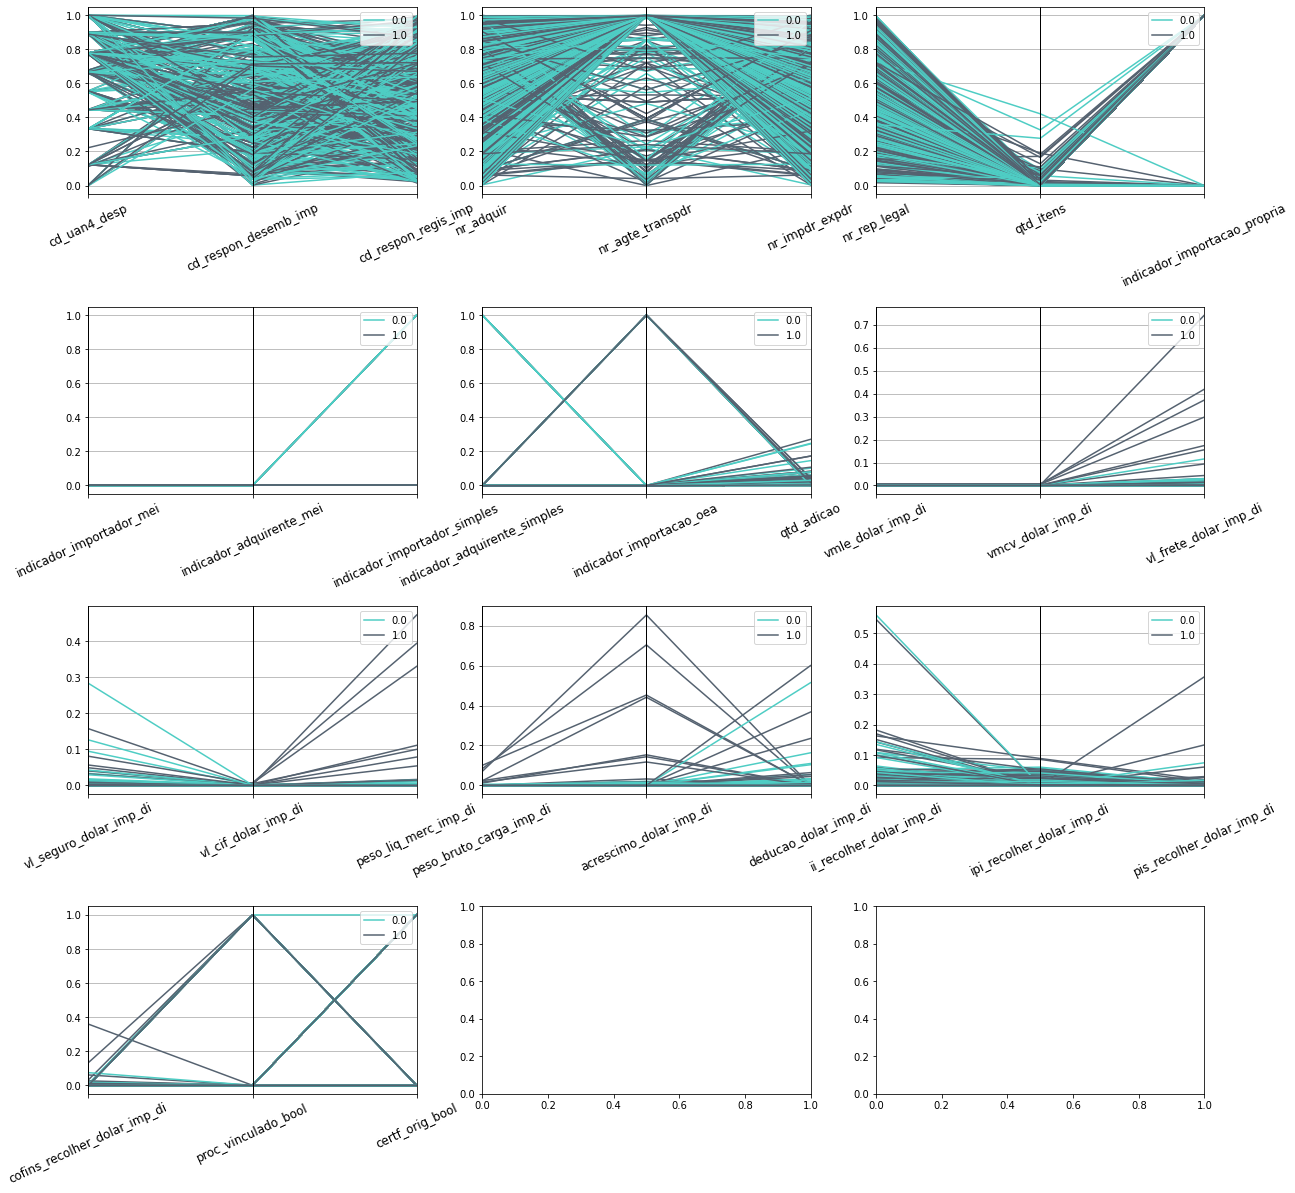

In [30]:
# Getting only the columns whose types are not "object"
cols = train_df.drop(columns=['cd_subitem_ncm', 'retificada']).columns.tolist()
eda_df = train_df.drop(columns=['cd_subitem_ncm']).groupby(cols, as_index=False).mean()
eda_df = eda_df.select_dtypes(exclude='object').drop(columns=['cd_di'])

# Instantiating MinMaxScaler pre-processing object
min_max_scaler = MinMaxScaler()
# Transforming - normalizing - the float columns. train_enc_ncm_norm_df has only the to be transformed columns 
X_scale = min_max_scaler.fit_transform(eda_df)
# Creating a dataframe from the normalized columns, so it can be merged to the train_enc_ncm_df. It has to have the same index as the train_enc_ncm_df to be merged.
norm_df = pd.DataFrame(X_scale, index=eda_df.index, columns=eda_df.columns)
# Join normalized dataframe and train_enc_ncm_df, getting train_enc_ncm_norm_df
# In order to not gererate duplicated columns, the normalized columns have to be dropped from the train_enc_ncm_df before the merging
eda_df = eda_df.drop(columns=norm_df.columns).merge(norm_df, how='inner', left_index=True, right_index=True)


# Dropping duplicated rows, so the operations can become less expensive 
eda_df = eda_df.drop_duplicates(keep='first')
# Selecting a random sample to create charts
eda_df = eda_df.sample(frac=.07)

# Quantity of features per axis
feat_per_axis_qtty = 3

#Quantity of feautues in the last axis (minus 1 beacuse the column "retificada" is the target)
feat_last_axis_qtty = (eda_df.columns.size-1) % 3

# getting the axis quantity
ax_qtty = math.ceil((eda_df.columns.size-1)/feat_per_axis_qtty)

# getting lines quantity (3 axis per line)
lines_qtty = math.ceil(ax_qtty/3)

# Creting the subplots
fig, axes_lst = plt.subplots(nrows=lines_qtty, ncols=3, sharey=False, figsize=(20,lines_qtty*5))

axis_count = 0

eda_df.columns
# lopp to run over the lines
for l in range(axes_lst.shape[0]):
    
    # running over the columns
    for c in range(axes_lst.shape[1]):
        axis_count +=1 
        axis_cols = eda_df.columns.values.tolist()[(axis_count*3-3):(axis_count*3)] + ['retificada']
        if axis_count < ax_qtty:
            ax = pd.plotting.parallel_coordinates(frame=eda_df[axis_cols],class_column='retificada', ax=axes_lst[l][c], color=['#4ECDC4', '#556270'])
            ax.set_xticklabels(ax.get_xticklabels(), rotation=25, fontsize='large')

fig.subplots_adjust(hspace = 0.6)    
    
plt.show()


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


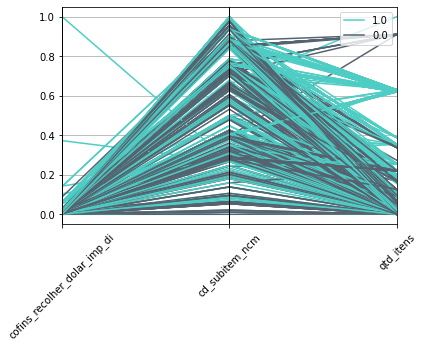

In [29]:
sample_df = util.get_di_sample(df=train_df, frac_di=0.05)[['cofins_recolher_dolar_imp_di','cd_subitem_ncm','qtd_itens','retificada']]

#Instantiating MinMaxScaler pre-processing object
min_max_scaler = MinMaxScaler()
# Transforming - normalizing - the float columns. train_enc_ncm_norm_df has only the to be transformed columns 
X_scale = min_max_scaler.fit_transform(sample_df)
# Creating a dataframe from the normalized columns, so it can be merged to the train_enc_ncm_df. It has to have the same index as the train_enc_ncm_df to be merged.
norm_df = pd.DataFrame(X_scale, index=sample_df.index, columns=sample_df.columns)
# Join normalized dataframe and train_enc_ncm_df, getting train_enc_ncm_norm_df
# In order to not gererate duplicated columns, the normalized columns have to be dropped from the train_enc_ncm_df before the merging
sample_df = sample_df.drop(columns=norm_df.columns).merge(norm_df, how='inner', left_index=True, right_index=True)

ax = pd.plotting.parallel_coordinates(frame=sample_df,class_column='retificada', color=['#4ECDC4', '#556270'])
xtick_labesl = ax.get_xticklabels()
ax.set_xticklabels(xtick_labesl, rotation=45)
plt.show()

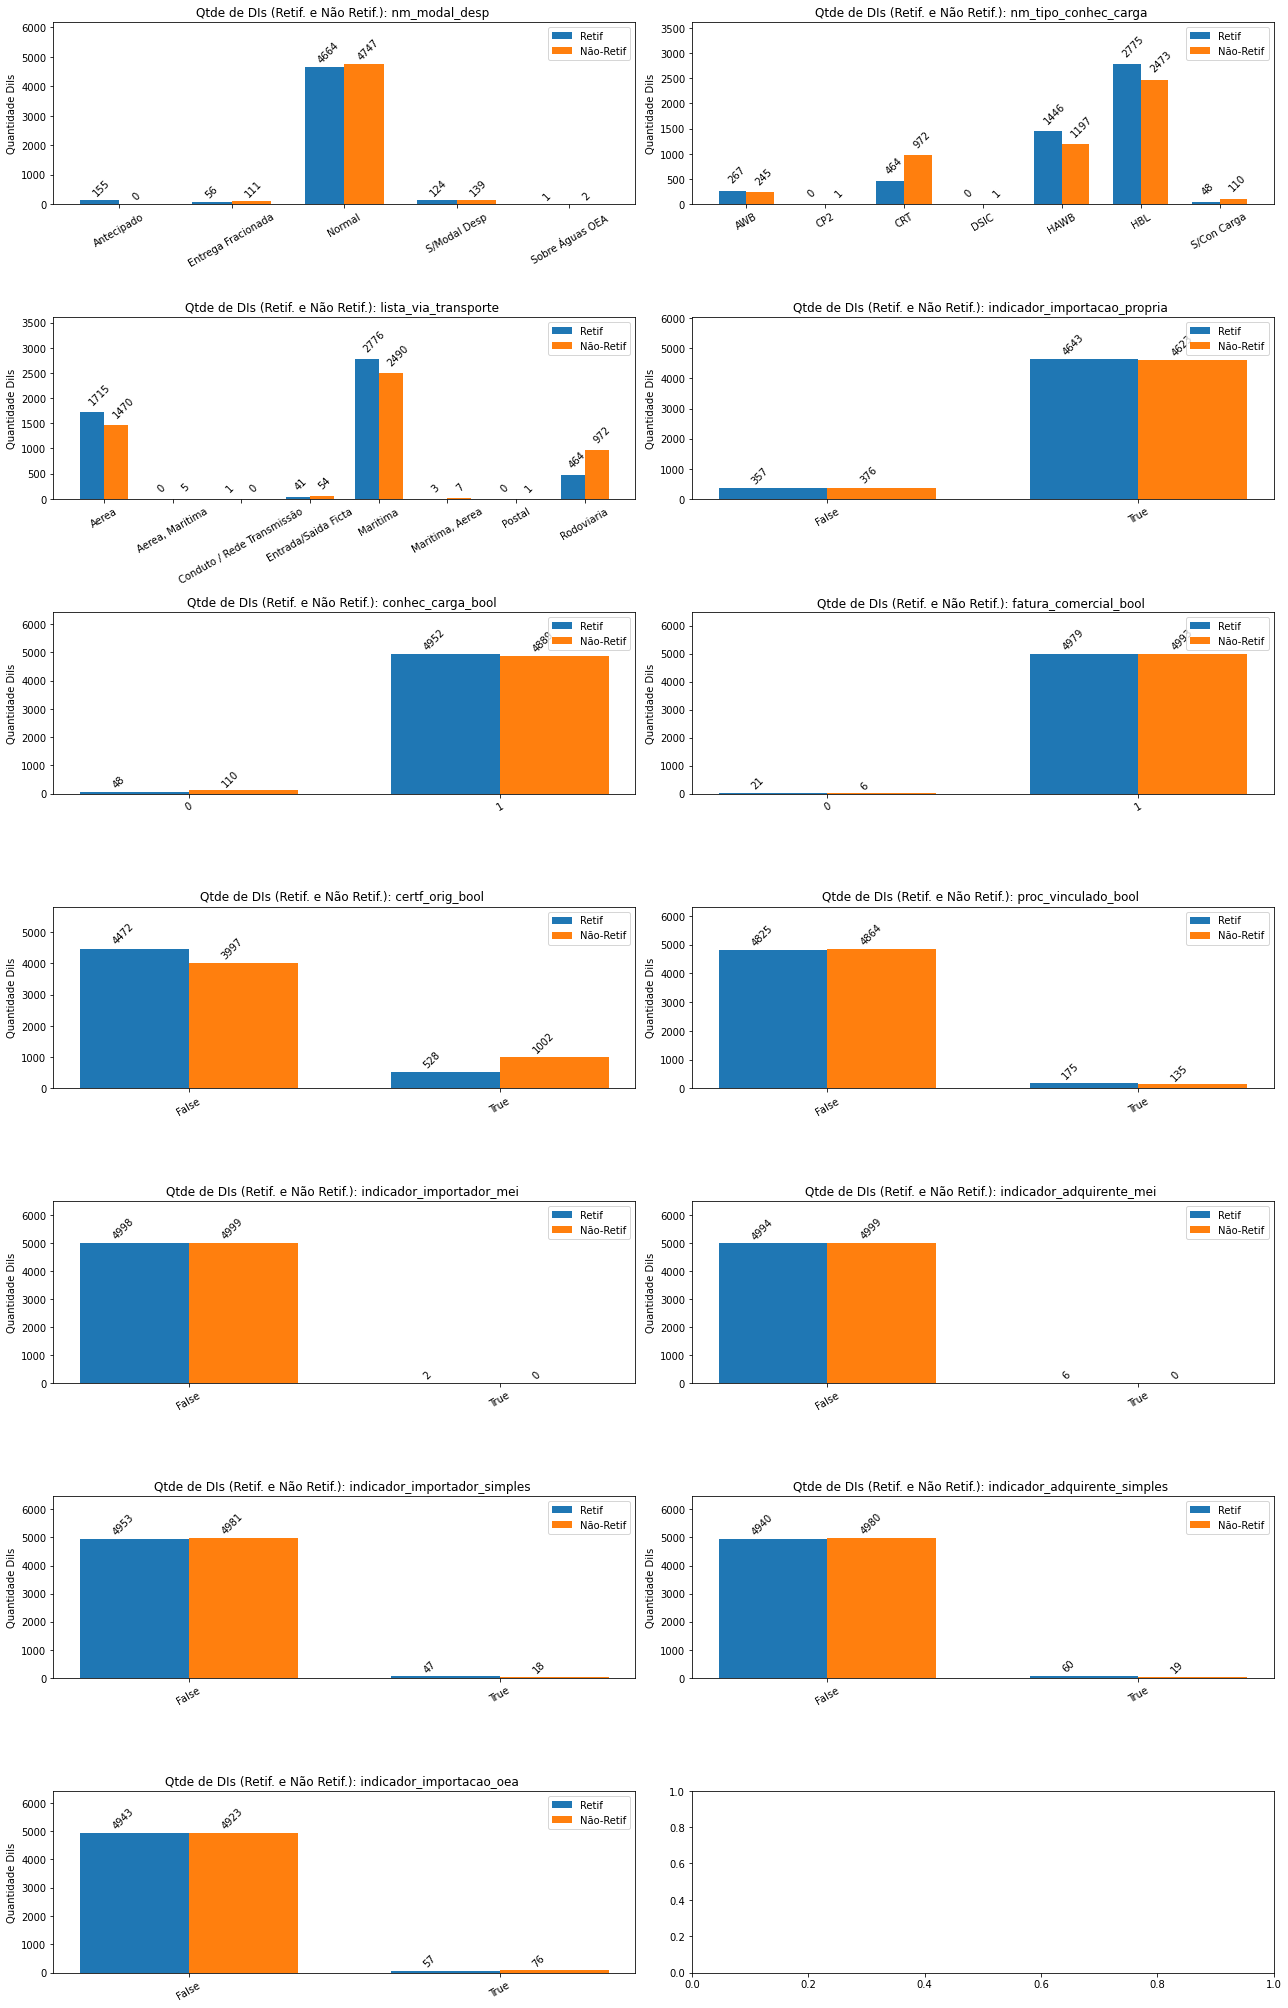

In [31]:
def get_groupd_df(train_df, col_name):
    cols = train_df.drop(columns=['cd_subitem_ncm', 'retificada']).columns.tolist()
    eda_df = train_df.drop(columns=['cd_subitem_ncm']).groupby(cols, as_index=False).mean()
    eda_df = eda_df.drop(columns=['cd_di'])
    aux_df = eda_df.copy()
    aux_df = aux_df[[col_name,'retificada']]
    aux_df['qtd_reg'] = 1

    aux_df = aux_df.groupby([col_name,'retificada'], as_index=False).sum()
    
    #### Filling missing values
    auxo_df2 = aux_df.groupby(col_name).count()
    
    # Iterating over the lines wich have only one value (rectified or not rectified)
    for x in auxo_df2[auxo_df2['retificada'] == 1].index.values:
        rectified = aux_df[aux_df[col_name] == x]['retificada'].values[0]

        if rectified == 1:
            aux_df.loc[aux_df.index.max()+1] = (x, 0, 0)
        else:
            aux_df.loc[aux_df.index.max()+1] = (x, 1, 0)
    
    return aux_df.sort_values(by=col_name).reset_index(drop=True)

def plot_bar_chart(df, ax, col_name):
    labels   = df[col_name].unique()
    retif    = df[df['retificada'] == 1]['qtd_reg'] 
    no_retif = df[df['retificada'] != 1]['qtd_reg']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(x - width/2, retif    , width, label='Retif')
    rects2 = ax.bar(x + width/2, no_retif , width, label='Não-Retif')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Quantidade DiIs')
    ax.set_title(f'Qtde de DIs (Retif. e Não Retif.): {col_name} ')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30)
    ax.legend()
    ax.set_ybound(lower=None, upper=df['qtd_reg'].max()*1.3)
    
    # Iterating over the bars
    for b in ax.patches:
        ax.text(x=b.get_x() + 0.1, y=b.get_height()+150, s=b.get_height(), rotation=45)

#########################################################################################
col_to_show = [
    'nm_modal_desp'    , 'nm_tipo_conhec_carga' , 'lista_via_transporte', 'indicador_importacao_propria',
    'conhec_carga_bool', 'fatura_comercial_bool', 'certf_orig_bool'     , 'proc_vinculado_bool'         ,
    'indicador_importador_mei', 'indicador_adquirente_mei', 'indicador_importador_simples',
    'indicador_adquirente_simples', 'indicador_importacao_oea'
]

cols_qtty  = 2
rows_qtty = math.ceil(len(col_to_show)/cols_qtty)
fig, axes = plt.subplots(nrows=rows_qtty, ncols=cols_qtty, sharey=False, figsize=(18, 4*rows_qtty))

l_index = 0
c_index = 0
for c in col_to_show:
    aux_df = get_groupd_df(train_df, c)
    plot_bar_chart(aux_df, axes[l_index][c_index] , c)
    
    c_index += 1
    
    if c_index > 1:
        l_index += 1
        c_index   = 0
#########################################################################################

fig.tight_layout()

plt.show()


## Treinando os modelos
- Será realizado um treinamento inicial do modelo com regressão logística
- Posteriormente, todos os modelos serão treinados dentro de uma função, que receberá o conjunto de dados e comparará a acurácia dos modelos.
- Em um primeiro momendo, a separação do dataset em treinamento e teste será realizada com base no train_test_split
- Posteriormente, na função, entende-se que a utilização do cross_validation é mais adequada.
- A valiação do modelo ocorrerá com base em:
   - acurácia: média de acertos sobre o total de elemtos classificados (positivos e negativos)
   - precisão: quantidade de acertos em relação à quantidade de classificaçõe positivas
   - recall: quantidade de acertos positivos em relação á quantidade real de positivos.
   - f-score: avaliação conjunta do recall e da precisão = 2 * (precisão * recall)/(precision + recall)
   

In [32]:
from sklearn.metrics import confusion_matrix
# logistic regression
log_reg = LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='auto')

# shuffle dataframe
for i in range(0,3):
    train_encoded_df = train_encoded_df.sample(frac=1)

df_sample = train_encoded_df.sample(frac=0.1)
X = df_sample.drop(columns=['retificada', 'cd_di'], inplace=False)
y = df_sample['retificada']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
log_reg.fit(X_train, y_train)

print(f"Score - train Test split: {log_reg.score(X_test, y_test)}")

# Confusion matrix
y_pred = log_reg.predict(X_test)

Score - train Test split: 0.6516129032258065


Matriz de confusão sem normalização
[[ 67 159]
 [ 57 337]]


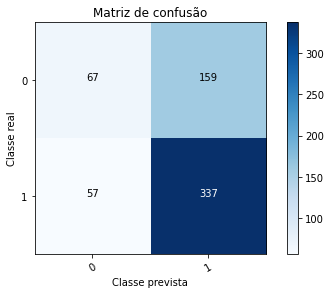

In [33]:
title = 'Matriz de confusão'
cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                              display_labels=log_reg.classes_)
#disp.plot()
#plt.show()
util.plot_confusion_matrix(
        cm, log_reg.classes_, 
        normalize=False,
        title="Matriz de confusão",
        cmap=plt.cm.Blues)

In [34]:
# Using cross-validation
import time
t1 = time.time()
cv_scores = cross_val_score(log_reg, X, y, cv=3, scoring='accuracy')
print(cv_scores)
print("X Validation score: {}".format(cv_scores.mean()))
time.time()-t1
#print("X Validation score: {}".format(cv_scores.)

[0.60212972 0.64437984 0.64888458]
X Validation score: 0.6317980474350179


23.552614212036133

### Dataset Original

In [35]:
df_sample = train_encoded_df.sample(frac=0.5)
X = df_sample.drop(columns=['retificada', 'cd_di'], inplace=False)
y = df_sample['retificada']

eval_df = util.evaluate_models(ds_name='original_enc', df=train_encoded_df, frac_di=0.5) #evaluate_models(X=X, y=y, ds_name='original')
eval_df

Testando Classifier: knn
Testando Classifier: log_reg
Testando Classifier: decision_tree
Testando Classifier: random_florest


knn  log_reg  decision_tree  \
original_enc fit_time_mean         45.47    53.42           7.28   
             score_time_mean      119.89    22.51          11.58   
             test_accuracy_mean     0.69     0.63           0.63   
             train_accuracy_mean    0.80     0.63           0.63   
             test_precision_mean    0.74     0.65           0.63   
             train_precision_mean   0.83     0.66           0.62   
             test_recall_mean       0.78     0.85           1.00   
             train_recall_mean      0.86     0.85           1.00   
             test_f1_mean           0.76     0.74           0.77   
             train_f1_mean          0.84     0.74           0.77   

                                   random_florest  
original_enc fit_time_mean                   6.76  
             score_time_mean                11.51  
             test_accuracy_mean              0.63  
             train_accuracy_mean             0.63  
             test_precision_mean             0.62  
             train_precision_mean            0.62  
             test_recall_mean                1.00  
             train_recall_mean               1.00  
             test_f1_mean                    0.77  
             train_f1_mean                   0.77

Rectangle(xy=(-0.4, 0), width=0.8, height=0.74076, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=0.654885, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=0.625624, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=0.62417, angle=0)


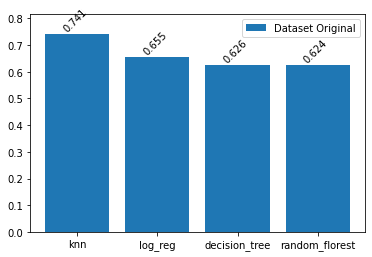

In [36]:
idx = pd.IndexSlice
df_slice = eval_df.loc[idx[:, ['test_precision_mean'], idx[:] ]]

fig, ax = plt.subplots()
orig_bar = ax.bar(df_slice.columns.values, df_slice.values[0])
ax.set_ybound(lower=0, upper=max(df_slice.values[0])*1.1)

ax.legend([orig_bar], ['Dataset Original'])

for b in orig_bar:
    print(b)
    plt.text(b.xy[0]+0.2,b.get_height()+0.01,round(b.get_height(),3), rotation=45)
plt.show()

In [37]:
# Lack of memory
# Saving data do use in another notebook
train_encoded_df.to_csv('train_encoded_df.csv')

cols_list_df.to_csv('cols_list_df.csv')

df = pd.DataFrame(train_encoded_df.dtypes, columns=['col_type'])
df.index.name = 'col_name'
df.to_csv('train_encoded_df_dtypes.csv')

eval_df.to_csv('eval_df.csv')
df = pd.DataFrame(eval_df.dtypes,columns=['col_type'])
df.index.name = 'col_name'
df.to_csv('eval_df_dtypes.csv')